In [121]:
# Import libraries
import tensorflow as tf

import keras


from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D
from keras.utils  import to_categorical
from keras.regularizers import L2


import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('default')

# LaTeX font in plot
mpl.rc('text', usetex = True)
mpl.rc('font', family = 'serif')


# Helper libraries
import time
import datetime

import numpy as np
import pandas as pd
import sklearn
from   sklearn.model_selection import train_test_split

In [122]:
# Reading the energy data with pandas
cols_energy = ['Date','Energy']
energy      = pd.read_excel(r'/Users/jonatanharaldsson/Library/CloudStorage/Dropbox/Utbildning/Sabbatsår/Deep_Learning/Eget_projekt/proj_data/energy.xlsx')
df_energy   = pd.DataFrame(energy,columns = cols_energy)

# Setting date as an index
df_energy['Time'] = pd.to_datetime(df_energy['Date'])
df_energy = df_energy.drop(['Date'],axis=1)
df_energy = df_energy.set_index('Time')

display(df_energy)


,Energy
Time,
2016-10-12 00:00:00,1.69
2016-10-12 01:00:00,1.69
2016-10-12 02:00:00,1.71
2016-10-12 03:00:00,2.23
2016-10-12 04:00:00,1.82
...,...
2024-01-01 19:00:00,4.53
2024-01-01 20:00:00,6.08
2024-01-01 21:00:00,4.19


In [123]:
# Reading the temp. data with pandas
cols_temp = ['Date and time','Temp']
temp      = pd.read_excel(r'/Users/jonatanharaldsson/Library/CloudStorage/Dropbox/Utbildning/Sabbatsår/Deep_Learning/Eget_projekt/proj_data/temp.xlsx')
df_temp   = pd.DataFrame(temp,columns = cols_temp)

# Setting date as an index
df_temp['Time'] = pd.to_datetime(df_temp['Date and time'])
df_temp         = df_temp.drop(['Date and time'],axis=1)
df_temp         = df_temp.set_index('Time')

display(df_temp)


,Temp
Time,
2016-10-12 00:00:00,6.7
2016-10-12 01:00:00,7.1
2016-10-12 02:00:00,7.3
2016-10-12 03:00:00,7.4
2016-10-12 04:00:00,7.6
...,...
2024-01-01 19:00:00,0.1
2024-01-01 20:00:00,-0.2
2024-01-01 21:00:00,-0.4


## Checking the datasets if there are any dates that are missing

**Source**: The code for obtaining the daterange missing dates was inspired by the code found here: https://www.geeksforgeeks.org/check-missing-dates-in-pandas/

In [124]:
# Check for missing dates
df_energy.index = pd.to_datetime(df_energy.index)
missing_dates_energy = pd.date_range(start=df_energy.index[0], end=df_energy.index[-1], freq='h').difference(df_energy.index)
print('Missing values energy',len(missing_dates_energy))

df_temp.index = pd.to_datetime(df_temp.index)
missing_dates_temp = pd.date_range(start=df_temp.index[0], end=df_temp.index[-1], freq='h').difference(df_temp.index)
print('Missing values temp',len(missing_dates_temp))


Missing values energy 0
Missing values temp 899


## Handling the missed values in temp series
In the two coming code snippets the missing temperature values are inserted into the temperature data frame. I struggled a bit with this one, but I managed to get it to work by importing the temperature values again. I'll admit that it isn't the best solution it does the job. 



Text(0, 0.5, 'Temp [°C]')

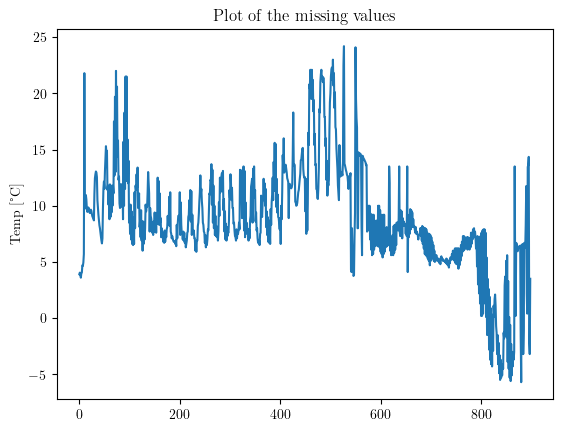

In [125]:
'''Replaceing missing values in the temperature data frame with the mean of previous and coming days.'''

list_missed_value = []
dt_d = pd.Timedelta(hours=24)
dt_y = pd.Timedelta(hours=24*365)
dt_h = pd.Timedelta(hours = 1)

for i,j in zip(missing_dates_temp,range(0,len(missing_dates_temp))):

        if i + dt_d not in missing_dates_temp:    
                n = 0
                error = True
                while error:
                        try:
                                next_val = df_temp['Temp'][i + n * dt_d]
                                error = False
                        except:
                                n+=1

        if i - dt_d not in missing_dates_temp:
                n = 0
                error = True
                while error:
                        try:
                                pre_val = df_temp['Temp'][i - n * dt_d]
                                error = False
                        except:
                                n+=1

        mean_value = np.mean([pre_val,next_val])
        list_missed_value.append(mean_value)
        
        if len(list_missed_value)> 3 and list_missed_value[j] == list_missed_value[j-1]:
                try: 
                        list_missed_value[j] = df_temp['Temp'][i - dt_y]
                        list_missed_value[j-1] = df_temp['Temp'][i - dt_y - dt_d]
                except: 
                        list_missed_value[j] = df_temp['Temp'][i + dt_y]
        

plt.plot(list_missed_value)
plt.title('Plot of the missing values')
plt.ylabel('Temp [°C]')

In [126]:
# Reading in the temperatures again...

temp_2      = pd.read_excel(r'/Users/jonatanharaldsson/Library/CloudStorage/Dropbox/Utbildning/Sabbatsår/Deep_Learning/Eget_projekt/proj_data/temp.xlsx')
df_temp_2   = pd.DataFrame(temp_2,columns = cols_temp)

# Adding missed temp and values to a data frame

df_missed_temp = pd.DataFrame({cols_temp[0]:missing_dates_temp,cols_temp[1]:list_missed_value})

for i,date in zip(range(0,len(missing_dates_temp)),missing_dates_temp):
    val = pd.DataFrame({cols_temp[0]:missing_dates_temp[i],cols_temp[1]:list_missed_value[i]}, index=[i])
    
    shift = date - dt_h                                     # Shift = missing date - 1 hour, a value that certainly exist in the dataset

    i_start = np.where(df_temp_2['Date and time'] == shift) # Since I struggled with slicing with the datetime indices, I obtained the index with np.where and then used .iloc to slice

    i_start = int(i_start[0][0])

    df_temp_2 = pd.concat([df_temp_2.iloc[:i_start],val,df_temp_2.iloc[i_start:]],ignore_index=True) 

print('Missing values in Temp dataset:', len(df_temp_2)-len(df_energy))


Missing values in Temp dataset: 0


## Merge of datasets

In [127]:
df_temp = df_temp_2
df_temp['Time'] = pd.to_datetime(df_temp['Date and time'])
df_temp         = df_temp.drop(['Date and time'],axis=1)
df_temp         = df_temp.set_index('Time')

display(df_temp)

,Temp
Time,
2016-10-12 00:00:00,6.7
2016-10-12 01:00:00,7.1
2016-10-12 02:00:00,7.3
2016-10-12 03:00:00,7.4
2016-10-12 04:00:00,7.6
...,...
2024-01-01 19:00:00,0.1
2024-01-01 20:00:00,-0.2
2024-01-01 21:00:00,-0.4


In [128]:
# Merging the two datasets into one dataframe

df_energy.insert(1,'Temp',df_temp['Temp'],True)

df = df_energy

#display(df)
df.describe()

,Energy,Temp
count,63312.000000,63312.000000
mean,2.050134,9.539933
std,1.088434,7.373051
min,0.000000,-13.700000
25%,1.190000,4.100000
50%,1.970000,9.000000
75%,2.680000,15.325000
max,14.280000,33.300000


## Sunrise equation 

This equation provides the sunrise and sunset times for a location depending on latitud $\varphi$. To obtain the daytime or "hours with sunlight", the sunrise time is subtracted from the sunrise time.

Link to source: https://www.bristol.ac.uk/media-library/sites/engineering/engineering-mathematics/documents/modelling/teacher/daylength_t.pdf


When testing the equations, it seems to be working quite well. I also added the mid winter solstice (dec 21) to the plot and it is at the shortest day!! In addition, if daytime is calculated for Kiruna, a city north of the artic circle, then the works with the mid winter and summer sun. 


In [129]:
# Adding number of hours with daylight to the dataset
# Sunrise equation
def daylight(start_date,h,incl,summertime):
    avg_year = 365.2524
    h = h - start_date*24                                            # Shifting it, since the data doesn't begin at 1st jan
    delta = 23.45 * np.cos(np.deg2rad(360/avg_year * (h/24 - 172)))  # Given at the source 
    phi = incl
    cos_om = -np.tan(np.deg2rad(phi))*np.tan(np.deg2rad(delta))
    om = np.rad2deg(np.arccos(cos_om))
    if summertime == True:
        sunrise = 13-om/15
        sunset  = 13+om/15
    else:
        sunrise = 12-om/15
        sunset  = 12+om/15
    daytime = sunset-sunrise    
    solar_ang = (daytime*np.sin(2*np.pi * (h/24))/2 + daytime)/np.max(daytime)

    return sunrise,sunset,om, solar_ang

/var/folders/xl/schcbct544b8f32_b4484x5c0000gn/T/ipykernel_56255/3562246921.py:9: RuntimeWarning: invalid value encountered in arccos
  om = np.rad2deg(np.arccos(cos_om))


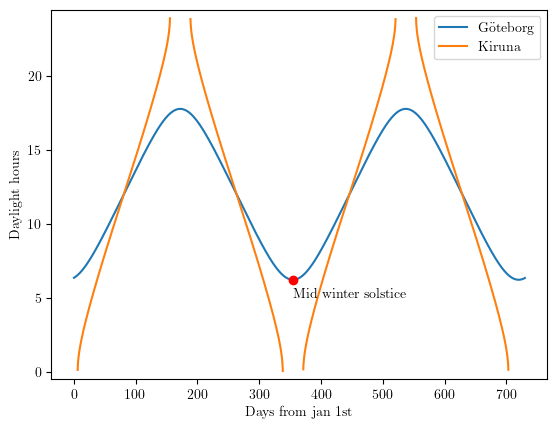

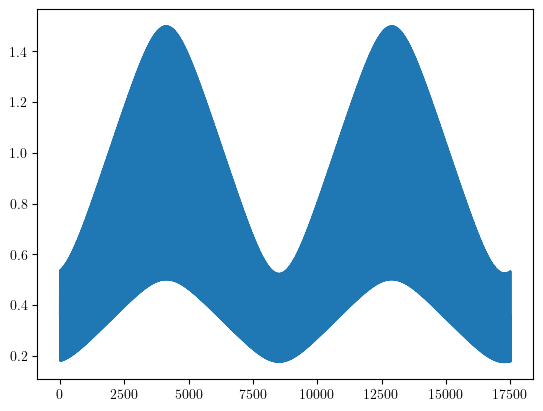

In [130]:
 # Testing the sunrise and sunset function

incl_gbg = 57.71
h = np.linspace(0,2*365*24,2*365*24)
sunrise_gbg,sunset_gbg,om,solar_ang_gbg = daylight(0,h,incl_gbg,summertime=True)
daytime_gbg = sunset_gbg-sunrise_gbg
plt.plot(h/24,daytime_gbg)



incl_kiruna = 67.50
sunrise_kiruna,sunset_kiruna,om,_ = daylight(0,h,incl_kiruna,summertime=True)
daytime_kiruna = sunset_kiruna-sunrise_kiruna
plt.plot(h/24,daytime_kiruna)

dec_21 = 365-11
sunrise_dec21, sunset_dec21,_,_ = daylight(0,24*dec_21,incl_gbg,True)

daytime_dec21 = sunset_dec21-sunrise_dec21

plt.ylim([-0.5,24.5])
plt.xlabel('Days from jan 1st')
plt.ylabel('Daylight hours')
plt.plot(dec_21,daytime_dec21,'ro')
plt.text(dec_21,5,'Mid winter solstice')
plt.legend(['Göteborg','Kiruna'])
plt.show()

plt.plot(h,solar_ang_gbg)
plt.show()


## Adding daytime and solar ang to dataset

In [131]:
num_hours   = np.linspace(0,len(df['Energy'])-1,len(df['Energy']))
start_date  = 81 # data starts at 2016-10-12, 80 days from 2016-12-31
incl_gbg = 57.71

sunrise,sunset,om,solar_ang = daylight(start_date,num_hours,incl_gbg,True)

daytime = sunset - sunrise

df['Daytime'] = daytime
df['Solar_ang'] = solar_ang


**The rolling average function**

This function was inspired by the rolling average function found in section 2.1 here: https://www.kaggle.com/code/dimitriosroussis/electricity-price-forecasting-with-dnns-eda/notebook#Table-of-Contents

In [132]:
# Rolling average function
def rolling_average(data,N_days):
    avg = data.rolling(24*N_days,center=True).mean()
    return avg

## Taking a look at the data

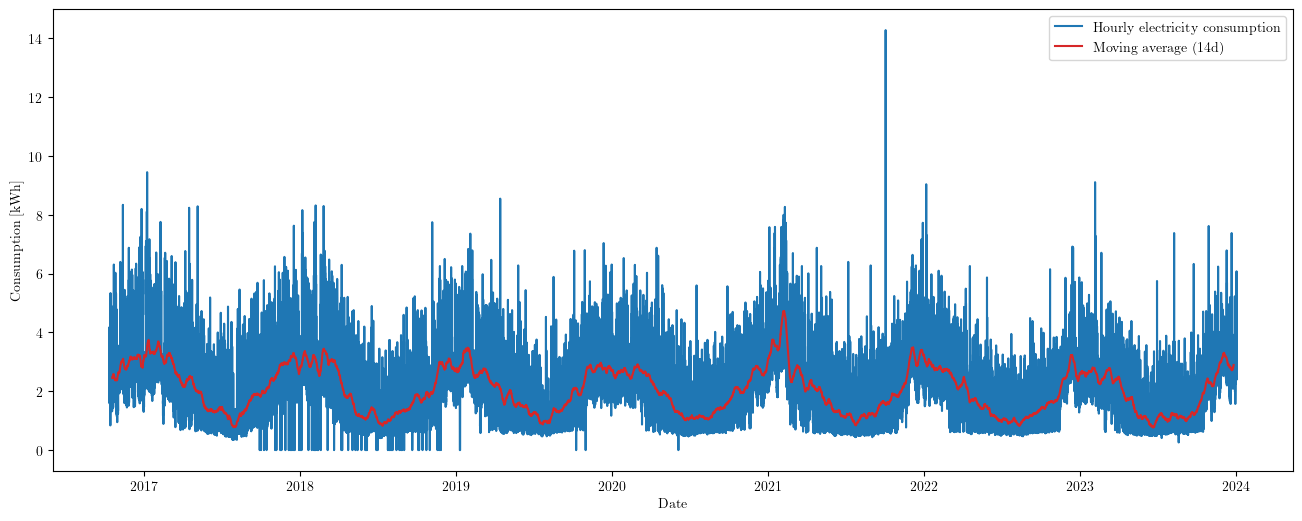

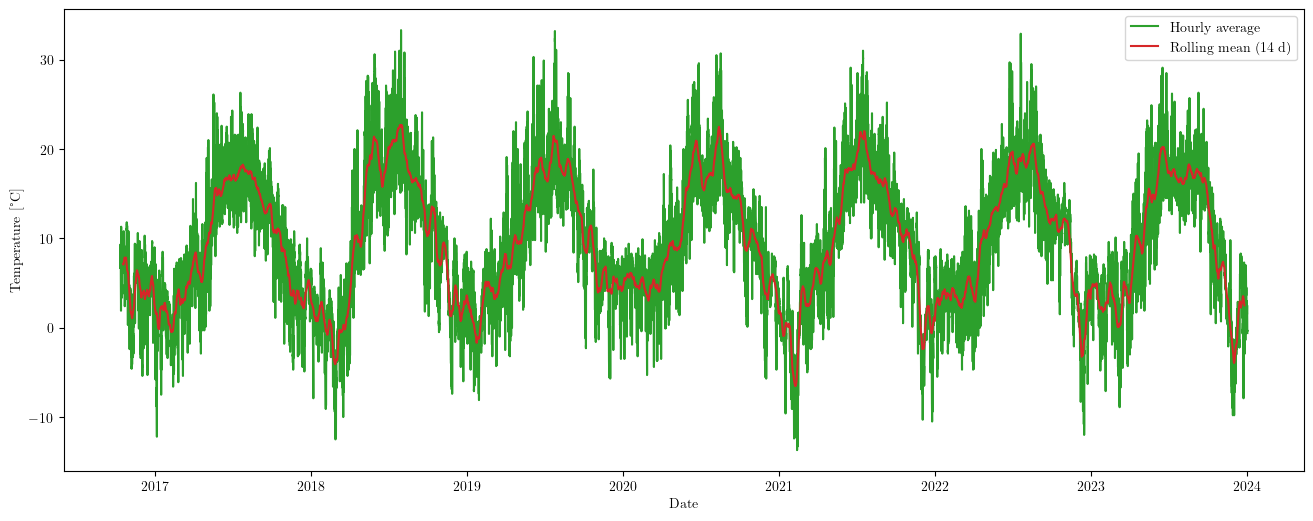

In [133]:

consumption = df['Energy']

plt.figure(figsize=(16,6))
plt.plot(consumption,color='tab:blue')
plt.xlabel('Date')
plt.ylabel('Consumption [kWh]')

num_days_avg = 14
plt.plot(rolling_average(consumption,num_days_avg),'tab:red')

plt.legend(['Hourly electricity consumption',f'Moving average ({num_days_avg}d)'])
plt.show()


temperature = df['Temp']

plt.figure(figsize=(16,6))
plt.plot(temperature,color='tab:green')
plt.xlabel('Date')
plt.ylabel('Temperature [°C]')

num_days_avg = 14
plt.plot(rolling_average(temperature,num_days_avg),'tab:red')

plt.legend(['Hourly average',f'Rolling mean ({num_days_avg} d)'])
#plt.savefig('temp.pdf')
plt.show()


## Taking a look at the distribution

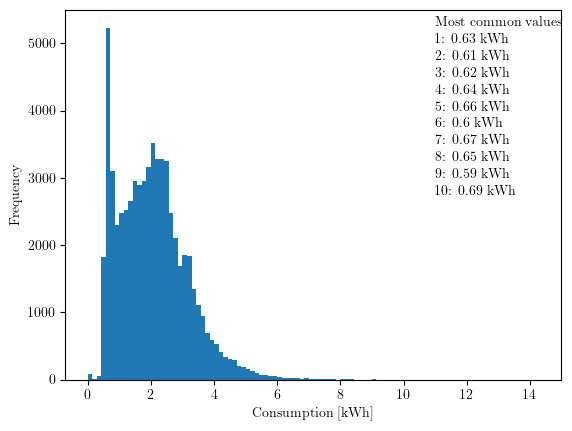

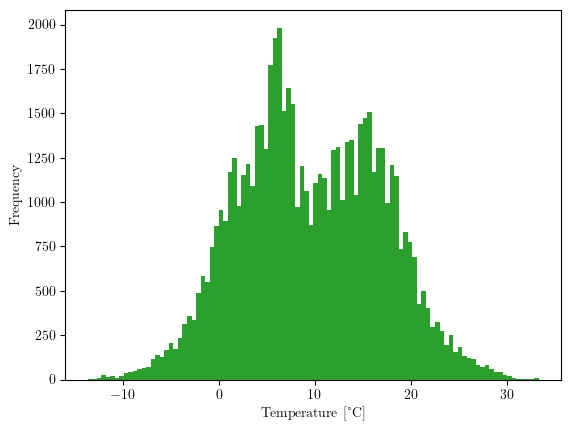

In [134]:
most_common = consumption.value_counts()

number_to_plot = 10
for i,n in zip(most_common.index[:number_to_plot],range(0,len(most_common.index[:number_to_plot]))):
    x = 11;y = 5000;dy = 250
    if n == 0:
        plt.text(x,y+dy,'Most common values')
    plt.text(x,y-dy*n,f'{n+1}: {i} kWh')

consumption.plot.hist(bins = 100)
plt.xlabel('Consumption [kWh]')
plt.show()

temperature.plot.hist(bins = 100,color='tab:green')
plt.xlabel('Temperature [°C]')
plt.show()

## Dealing with some outliers in the energy dataset

Some values in the energy dataset are equal to zero, which corresponds with times of power shortages. To make the data less erroneous these values are set to the mean of the previous and next day. 

One of the highest values are also replaced with the means of the adjecent days.

In [136]:
num_zero = np.count_nonzero(df['Energy'] == 0) 
print('Number of zero values in energy previously:',num_zero)


# Dealing with all the zero values in Energy
if num_zero != 0:
    com_matrix = df['Energy'] == 0

    for i,j in zip(com_matrix,com_matrix.index):
        if i:
            ind = len(df['Energy'][:j])-1
            df['Energy'][j] = np.mean([df['Energy'].iloc[ind-24],df['Energy'].iloc[ind+24]])

    com_matrix = df['Energy'] > .95 * max(df['Energy'])

    for i,j in zip(com_matrix,com_matrix.index):
        if i:
            ind = len(df['Energy'][:j])-1
            df['Energy'][j] = np.mean([df['Energy'].iloc[ind-24],df['Energy'].iloc[ind+24]])

num_zero = np.count_nonzero(df['Energy'] == 0) 
print('Number of zero values in energy now:',num_zero)

Number of zero values in energy previously: 87
Number of zero values in energy now: 0


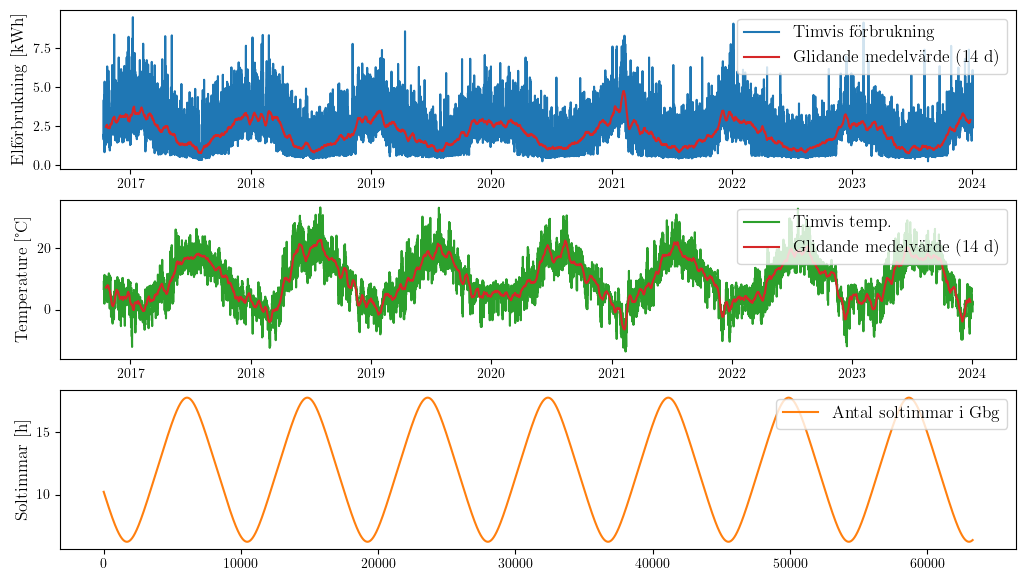

In [103]:
fontsize = 12.5
fig, axs = plt.subplots(3,1)
fig.set_size_inches(18.5/1.5, 10.5/1.5)

# Plotting energy values
axs[0].plot(df['Energy'],color='tab:blue') 
axs[0].set_ylabel('Elförbrukning [kWh]',fontsize = fontsize)
axs[0].plot(rolling_average(df['Energy'],num_days_avg),'tab:red')

# Plotting temp. values
axs[1].plot(temperature,color='tab:green')
axs[1].set_ylabel('Temperature [°C]',fontsize = fontsize)
axs[1].plot(rolling_average(temperature,num_days_avg),'tab:red')

# Plotting daytime values
axs[2].plot(daytime,color='tab:orange')
axs[2].set_ylabel('Soltimmar [h]',fontsize = fontsize)

# Legends
axs[1].legend(['Timvis temp.',f'Glidande medelvärde ({num_days_avg} d)'],loc='upper right',fontsize = fontsize)
axs[0].legend(['Timvis förbrukning',f'Glidande medelvärde ({num_days_avg} d)'],loc='upper right',fontsize = fontsize)
axs[2].legend(['Antal soltimmar i Gbg'],loc='upper right',fontsize = fontsize)

fig.savefig('data1.pdf')

In [59]:
df.describe()

,Energy,Temp,Daytime,Solar_ang
count,63312.000000,63312.000000,63312.000000,63312.000000
mean,2.053116,9.539933,11.863001,0.667226
std,1.085291,7.373051,3.940529,0.333034
min,0.260000,-13.700000,6.220248,0.174925
25%,1.190000,4.100000,8.074838,0.414452
50%,1.970000,9.000000,11.753295,0.578867
75%,2.690000,15.325000,15.639442,0.880412
max,9.450000,33.300000,17.779752,1.500000


## Normalize the data

The function for normalizing are taken from the code given in lab 3.

In [60]:
def norm_data(X):
    X_avg = X.mean()
    X_std = X.std()
    X_new = (X - X_avg)/X_std
    return X_new, X_avg, X_std

In [61]:
# Unnormalize the data in a similar fashion as the norm function above. 

def unnormdata(X,old_avg,old_std):
    X_new = X * old_std[0] + old_avg[0]
    return X_new

In [62]:
df_norm, df_avg, df_std = norm_data(df)
df_norm.describe()

,Energy,Temp,Daytime,Solar_ang
count,6.331200e+04,6.331200e+04,6.331200e+04,6.331200e+04
mean,-2.154792e-16,-2.154792e-17,-5.458807e-16,-1.292875e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.652199e+00,-3.152010e+00,-1.431979e+00,-1.478229e+00
25%,-7.952854e-01,-7.378130e-01,-9.613336e-01,-7.590035e-01
50%,-7.658402e-02,-7.323063e-02,-2.784050e-02,-2.653152e-01
75%,5.868326e-01,7.846232e-01,9.583589e-01,6.401311e-01
max,6.815578e+00,3.222556e+00,1.501512e+00,2.500565e+00


## Splitting the data into train, val and test data

In [63]:
# splittning the dataset into train, val and test data
N = len(df_norm)
split_list = [int(0.7*N),int(0.7*N)+int(0.2*N),N]

df_train = df_norm.iloc[:split_list[0]]
df_val   = df_norm.iloc[split_list[0]:split_list[1]]
df_test  = df_norm.iloc[split_list[1]:split_list[2]]

print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(44318, 4)
(12662, 4)
(6332, 4)


## Function to generate sequences that can be used for training.
This function is inspired by ... `multivariate_data` in section 3.2 found here https://www.kaggle.com/code/dimitriosroussis/electricity-price-forecasting-with-dnns-eda/notebook#Table-of-Contents


In [64]:
def generate_seq(dataset, target_col, history_size, target_size):
    X = [];y = []
    target = dataset[target_col]

    for i in range(history_size, len(dataset)-target_size):
        indices_X = range(i-history_size, i, 1)
        indices_y = range(i, i+target_size, 1)
        X.append(dataset.iloc[indices_X])
        y.append(target.iloc[indices_y])
    return X,y

In [65]:
history_hours = 24*3                    # Number of hours as input for the models 
hours_to_predict  = 24                  # Number of hours as output for the models, hours to predict 

prediction_param = 'Energy'

X_train, y_train = generate_seq(df_train, prediction_param, history_hours, hours_to_predict)

X_val, y_val     = generate_seq(df_val, prediction_param, history_hours, hours_to_predict)

X_test, y_test   = generate_seq(df_test, prediction_param, history_hours, hours_to_predict)


In [66]:
# Converting to np.array

X_train = np.array(X_train); y_train = np.array(y_train)
X_val = np.array(X_val); y_val = np.array(y_val)
X_test = np.array(X_test); y_test = np.array(y_test)


print(f'X_train shape: {X_train.shape}\t y_train shape: {y_train.shape}')
print(f'X_val shape: {X_val.shape}\t y_val shape: {y_val.shape}')
print(f'X_test shape: {X_test.shape}\t y_test shape: {y_test.shape}')


X_train shape: (44222, 72, 4)	 y_train shape: (44222, 24)
X_val shape: (12566, 72, 4)	 y_val shape: (12566, 24)
X_test shape: (6236, 72, 4)	 y_test shape: (6236, 24)


## A function for compiling and running the models



In [67]:
def training(model,epochs,loss_function, metric, learning_rate, patience):
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',patience=patience,mode='min',restore_best_weights = True)

    model.compile(loss=loss_function,
                optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
                metrics=[metric])

    start = time.time()
    history = model.fit(X_train,y_train, epochs=epochs,validation_data=(X_val,y_val),callbacks=[early_stopping])
    end = time.time()
    t = end-start
    print(f'Time to run: {t:.1f}s')

    return history,model,t

## Models

In [68]:
# First LSTM model. A simple LSTM model with one more Dense layer

lstm_model0 = keras.models.Sequential([

    keras.layers.LSTM(64, return_sequences=False),

    keras.layers.Dense(units=hours_to_predict*2, activation='relu'),
    
    keras.layers.Dense(units=hours_to_predict)
])

In [69]:
# Second model RNN

lstm_model1 = keras.models.Sequential([

    keras.layers.LSTM(256, return_sequences=True,recurrent_regularizer=L2(0.1)),
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.LSTM(32, return_sequences=False),

    keras.layers.Dense(units=hours_to_predict*2, activation='relu'),
    keras.layers.Dense(units=hours_to_predict)
])

In [70]:
# Thrid model BiDirectional LSTM

lstm_model2 = keras.models.Sequential([
    keras.layers.Bidirectional(keras.layers.LSTM(32,recurrent_regularizer=L2(0.01),return_sequences=True)),
    keras.layers.LSTM(32,recurrent_regularizer=L2(0.01)),
    keras.layers.Dense(units=hours_to_predict)
])

In [71]:
# Fourth model LSTM

lstm_model3 = keras.models.Sequential([

    keras.layers.LSTM(32, return_sequences=False),
    
    keras.layers.Dense(units=hours_to_predict)
])

In [72]:
# First simple RNN model
simple_RNN_1 = keras.models.Sequential([
    keras.layers.SimpleRNN(32,return_sequences=False),
    keras.layers.Dense(units=hours_to_predict)
])

In [73]:
GRU_model_1 = keras.models.Sequential([
    keras.layers.GRU(32),
    keras.layers.Dense(units=hours_to_predict)
])

In [74]:
CNN_model_1 = keras.models.Sequential([
    keras.layers.Conv1D(filters = 72, kernel_size=3,padding='same',activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(units=hours_to_predict)
])

In [75]:
# This one was added just for fun. 

copy_of_tune_w_reg = keras.models.Sequential([
    keras.layers.LSTM(units = 160,return_sequences=True,recurrent_regularizer=L2(0.1)),
    keras.layers.LSTM(units = 96,return_sequences=False),

    keras.layers.Dense(units=72, activation='relu'),
    keras.layers.Dense(units=hours_to_predict)
])

## Running the models 

In [76]:
# Trying out different losses,
loss           = {'MSE':tf.losses.MeanSquaredError(),'Huber':tf.losses.Huber(),
                  'MAE':tf.losses.MeanAbsoluteError()}
# different metrics,
metrics        = {'MAE':tf.metrics.MeanAbsoluteError(),'MSE':tf.metrics.MeanSquaredError()}

# different learnings rates,
learning_rates = [1e-1,1e-2,5e-3,1e-3,5e-4]

max_epochs     = 25
patience       = 5  

models         = {'Simple LSTM':lstm_model0, 'Many layers LSTM':lstm_model1, 'Bidirectional':lstm_model2, 'One LSTM layer': lstm_model3
            ,'Simple RNN':simple_RNN_1,'GRU':GRU_model_1,'CNN model 1':CNN_model_1, 'Copy tuned':copy_of_tune_w_reg}

# Saving the choices in order to automatically save them to excel 
model_choice    = 'Many layers LSTM'
model_to_train  = models.get(model_choice)

lr_choice       = learning_rates[3]

loss_choice     = 'Huber'
loss_func       = loss.get(loss_choice) 

metric_choice   = 'MAE'
metric_func     = metrics.get(metric_choice) 


# Running the training
hist_model, model_run, time_to_run = training(model = model_to_train,epochs=max_epochs,loss_function = loss_func, 
                                           metric = metric_func, learning_rate = lr_choice, patience = patience)


Epoch 1/25
1382/1382 ━━━━━━━━━━━━━━━━━━━━ 158s 113ms/step - loss: 1.9202 - mean_absolute_error: 0.5264 - val_loss: 0.1582 - val_mean_absolute_error: 0.4436
Epoch 2/25
1382/1382 ━━━━━━━━━━━━━━━━━━━━ 159s 115ms/step - loss: 0.1800 - mean_absolute_error: 0.4623 - val_loss: 0.1527 - val_mean_absolute_error: 0.4303
Epoch 3/25
1382/1382 ━━━━━━━━━━━━━━━━━━━━ 161s 117ms/step - loss: 0.1767 - mean_absolute_error: 0.4563 - val_loss: 0.1584 - val_mean_absolute_error: 0.4346
Epoch 4/25
1382/1382 ━━━━━━━━━━━━━━━━━━━━ 160s 116ms/step - loss: 0.1730 - mean_absolute_error: 0.4510 - val_loss: 0.1583 - val_mean_absolute_error: 0.4368
Epoch 5/25
1382/1382 ━━━━━━━━━━━━━━━━━━━━ 161s 117ms/step - loss: 0.1686 - mean_absolute_error: 0.4433 - val_loss: 0.1594 - val_mean_absolute_error: 0.4323
Epoch 6/25
1382/1382 ━━━━━━━━━━━━━━━━━━━━ 167s 121ms/step - loss: 0.1638 - mean_absolute_error: 0.4356 - val_loss: 0.1739 - val_mean_absolute_error: 0.4645
Epoch 7/25
1382/1382 ━━━━━━━━━━━━━━━━━━━━ 161s 116ms/step - loss

## Saving the result to an excel document

In order to keep track of all changes that were made during training, the result during the tryouts were saved in an excel document. 

In [96]:
# Evaluating the model
metric_list = hist_model.history['mean_absolute_error']
loss_val,metric_val = model_run.evaluate(X_test,y_test)

# Printing the last MAE
print('MAE:',metric_val)

# Printing the last loss
print('Loss:',loss_val)

# Reading the excel document with all the previous runs
res_cols = ['Model','Metric','Metric Value','Loss','Loss Value','Time [s]','L. Rate','Epochs']
res_data = pd.read_excel(r'/Users/jonatanharaldsson/Library/CloudStorage/Dropbox/Utbildning/Sabbatsår/Deep_Learning/Eget_projekt/proj_data/res_data.xlsx')
df_res = pd.DataFrame(res_data,columns = res_cols)

# Append the data to a data frame. 
res_data_new ={ res_cols[0]:model_choice, res_cols[1]:metric_choice, res_cols[2]:metric_val,  res_cols[3]:loss_choice,
                res_cols[4]:loss_val,     res_cols[5]:time_to_run,   res_cols[6]:lr_choice,   res_cols[7]:len(metric_list)},


df_res_data_new = pd.DataFrame(res_data_new)


# Saving to the results to excel if it's not a duplicate

if df_res['Model'][len(df_res)-1] == df_res_data_new['Model'][0] and df_res['Metric Value'][len(df_res)-1] == df_res_data_new['Metric Value'][0]:
    print('Duplicate??')
else:
    df_res_new = pd.concat([df_res,df_res_data_new],ignore_index=True)
    
df_res_new.drop_duplicates

df_res_new.to_excel('/Users/jonatanharaldsson/Library/CloudStorage/Dropbox/Utbildning/Sabbatsår/Deep_Learning/Eget_projekt/proj_data/res_data.xlsx') 
df_res_new.tail()


195/195 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - loss: 0.1379 - mean_absolute_error: 0.4181
MAE: 0.4036494195461273
Loss: 0.1345295011997223


,Model,Metric,Metric Value,Loss,Loss Value,Time [s],L. Rate,Epochs
42,Bidirectional,MAE,0.485000,MSE,0.43400,422.000000,0.100,11
43,CNN model 1,MAE,0.490000,MSE,0.44100,36.700000,0.010,12
44,Many layers LSTM,MAE,0.813000,MSE,1.22000,1007.000000,0.100,7
45,CNN model 1,MAE,0.813000,MSE,1.06000,17.300000,0.100,6
46,Many layers LSTM,MAE,0.403649,Huber,0.13453,1127.973397,0.001,7


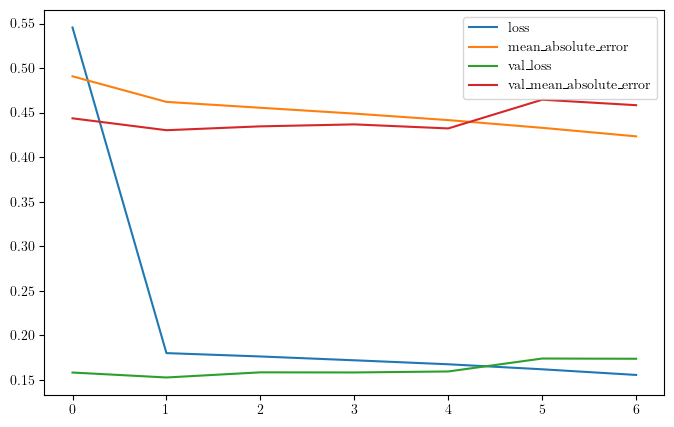

In [102]:
# Plot the training curves
pd.DataFrame(hist_model.history).plot(figsize=(8,5))
#plt.savefig('Training curves non tuned 5.pdf')

plt.show()

## Displaying the result and predicting future values

The idea to save the results into a dataframe and then plot the values originated from this video: https://www.youtube.com/watch?v=c0k-YLQGKjY

In [84]:
def plot_pred(model,X,y,start_index,index_hist,index_pred,dataname,save):

    '''This function plots the actual values the previous 72h and the coming 24h, along with a prediction of the next 24h'''
        
    axis_labels = ['Timmar [h]','Elförbrukning [kWh]']

    predictions     = model.predict(X)

    # Unnormalizing the data, so that it can be related to kWh again.
    predictions_unn = unnormdata(predictions,df_avg,df_std)
    y_unn           = unnormdata(y,df_avg,df_std)

    # Saving the prediction in a dataframe
    df_results = pd.DataFrame(data={'Predictions':predictions_unn[:,0], 'Actual values':y_unn[:,0]})
    
    # Plotting the result
    plt.figure(figsize=(12,4))
    plt.plot(df_results['Actual values'][start_index:index_hist],color='tab:blue',marker='.',linewidth=0.8)
    plt.plot(df_results['Actual values'][index_hist-1:index_pred],color='tab:blue',linestyle='dotted',marker='+',linewidth=0.8)
    plt.plot(df_results['Predictions'][index_hist:index_pred],color='tab:red',marker='+',linewidth=0.8)
    plt.legend(['Historiska värden 72 h','Faktiska värden 24 h','Prediktioner 24 h'])
    plt.xlabel(axis_labels[0])
    plt.ylabel(axis_labels[1])
    if dataname:
        plt.title(f'{dataname}')
    if save:
        plt.savefig(f'{dataname}.pdf')
    
    plt.show()

    return df_results

195/195 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step


/var/folders/xl/schcbct544b8f32_b4484x5c0000gn/T/ipykernel_56255/2933672459.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  X_new = X * old_std[0] + old_avg[0]


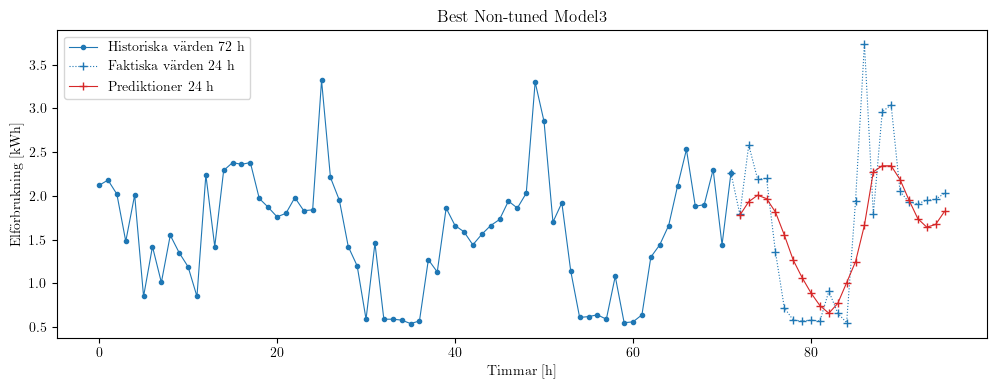

In [85]:
# Here one can choose how far into the data set to display predictions
start_index = 0
index_hist = start_index + history_hours
index_pred = start_index + history_hours + hours_to_predict

# Plotting prediction for the last trained model
res = plot_pred(model_run,X_test,y_test,start_index,index_hist,index_pred,dataname='Best Non-tuned Model3',save = False)

In [862]:
# Saving the model

if False:
    model_name = 'non_tuned_model'
    model_run.save(f'/Users/jonatanharaldsson/Library/CloudStorage/Dropbox/Utbildning/Sabbatsår/Deep_Learning/{model_name}.keras')

## Tuning model with Keras Autotune

In this section, a lot of the code was taken/inspired from the tuning done in lab 1. 

 

In [101]:
import keras_tuner

# The chosen optimization
from keras_tuner.tuners import BayesianOptimization

**Tuning setup**

Among the models above the _'Many layers LSTM'_ performed best. Due to long runtimes when tuning, the _'Many layers LSTM'_ -model had to be squeezed down into two layers instead of three. 

In the tryouts, the results for MAE varied a lot with different learning rates. That's why the learning rate was added as a parameter in addition to the units in LSTM and Dense layers. 

In [849]:
def build_model_MyModel(hp):
  model = keras.Sequential([
    # First LSTM Layer
    keras.layers.LSTM(
      units=hp.Int('units in LSTM_1', min_value=32, max_value=256, step=32),
      return_sequences = True
    ),
    
    keras.layers.LSTM(
      units=hp.Int('units in LSTM_2', min_value=32, max_value=128, step=32),
      return_sequences = False
    ),

    keras.layers.Dense(
      units=hp.Int('dense_1_units', min_value=24, max_value=72, step=8),
      activation='relu'),

    keras.layers.Dense(units = hours_to_predict)
  ])
  model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=learning_rates)),
              loss = tf.losses.Huber() ,
              #loss=hp.Choice('loss_function',[loss_f for loss_f in loss.values()]),
              metrics=['mean_absolute_error'])

  return model

In [850]:
MAX_TRIALS = 10            # This was set a bit lower just to ensure that running times were kept low  
EXECUTION_PER_TRIAL = 2 

In [851]:
class MyTuner(keras_tuner.tuners.BayesianOptimization):
  def run_trial(self, trial, *args, **kwargs):
    return super(MyTuner, self).run_trial(trial, *args, **kwargs)

In [852]:
tuner = MyTuner(
    build_model_MyModel,
    max_trials=MAX_TRIALS,
    objective='val_loss',
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory='output',
    overwrite=True,
    num_initial_points=10, 
    project_name='Tuner_energy_consumption'
)

**Running the Tuner**

In [853]:
tune = True

if tune:

    noepochauto = 6  
    es = keras.callbacks.EarlyStopping('val_loss', patience=3, restore_best_weights = True)
    
    tuner.search(X_train, y_train,
                epochs=noepochauto,
                validation_data=(X_val, y_val),
                callbacks=[es])

Trial 10 Complete [00h 10m 07s]
val_mean_absolute_error: 0.4255894869565964

Best val_mean_absolute_error So Far: 0.42326420545578003
Total elapsed time: 02h 27m 08s


In [854]:
# Get the best model from the tuner 
model = tuner.get_best_models(num_models=1)[0]

# Print the hyperparameters from the best model

vals = tuner.get_best_hyperparameters(num_trials=5)[0].values
for keys,values in vals.items():
    print('%20s = %3.4g' %(keys,values))

model.summary()

     units in LSTM_1 = 192
     units in LSTM_2 =  32
       dense_1_units =  48
       learning_rate = 0.001


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 72, 192)        │       151,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        28,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 48)             │         1,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 24)             │         1,176 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 182,856 (714.28 KB)

 Trainable params: 182,856 (714.28 KB)

 Non-trainable params: 0 (0.00 B)

## Futher training of the best model

In this section the best model from the tuner is trained even more. 

In [855]:
model = tuner.get_best_models(num_models=1)[0]

epochs = 30   

callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights = True)]

history = model.fit(
  X_train, y_train,
  epochs=epochs,
  verbose = 1,
  validation_data=(X_val, y_val),
  callbacks=callbacks
)

metric_list = history.history['mean_absolute_error']
metric_val = metric_list[-1]


Epoch 1/30


1382/1382 ━━━━━━━━━━━━━━━━━━━━ 77s 55ms/step - loss: 0.1655 - mean_absolute_error: 0.4414 - val_loss: 0.1553 - val_mean_absolute_error: 0.4331
Epoch 2/30
   3/1382 ━━━━━━━━━━━━━━━━━━━━ 1:10 51ms/step - loss: 0.1740 - mean_absolute_error: 0.4554

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `absolute_mean_error` which is not available. Available metrics are: loss,mean_absolute_error,val_loss,val_mean_absolute_error
  current = self.get_monitor_value(logs)


1382/1382 ━━━━━━━━━━━━━━━━━━━━ 77s 56ms/step - loss: 0.1560 - mean_absolute_error: 0.4269 - val_loss: 0.1583 - val_mean_absolute_error: 0.4393
Epoch 3/30
1382/1382 ━━━━━━━━━━━━━━━━━━━━ 77s 56ms/step - loss: 0.1438 - mean_absolute_error: 0.4085 - val_loss: 0.1762 - val_mean_absolute_error: 0.4656
Epoch 4/30
1382/1382 ━━━━━━━━━━━━━━━━━━━━ 77s 56ms/step - loss: 0.1316 - mean_absolute_error: 0.3889 - val_loss: 0.1760 - val_mean_absolute_error: 0.4610
Epoch 5/30
1382/1382 ━━━━━━━━━━━━━━━━━━━━ 80s 58ms/step - loss: 0.1216 - mean_absolute_error: 0.3722 - val_loss: 0.1774 - val_mean_absolute_error: 0.4640
Epoch 6/30
1382/1382 ━━━━━━━━━━━━━━━━━━━━ 79s 57ms/step - loss: 0.1136 - mean_absolute_error: 0.3585 - val_loss: 0.1874 - val_mean_absolute_error: 0.4779
Epoch 7/30
1382/1382 ━━━━━━━━━━━━━━━━━━━━ 79s 57ms/step - loss: 0.1095 - mean_absolute_error: 0.3511 - val_loss: 0.1894 - val_mean_absolute_error: 0.4819
Epoch 8/30
1382/1382 ━━━━━━━━━━━━━━━━━━━━ 80s 58ms/step - loss: 0.1043 - mean_absolute_

## Loading the previously saved models

The three tuned models that were saved are now loaded into the code for some analysis. 

In [86]:
model_tuned_1 = keras.models.load_model('/Users/jonatanharaldsson/Library/CloudStorage/Dropbox/Utbildning/Sabbatsår/Deep_Learning/tuned_model.keras')

model_tuned_2 = keras.models.load_model('/Users/jonatanharaldsson/Library/CloudStorage/Dropbox/Utbildning/Sabbatsår/Deep_Learning/tuned_model2.keras')

model_tuned_3 = keras.models.load_model('/Users/jonatanharaldsson/Library/CloudStorage/Dropbox/Utbildning/Sabbatsår/Deep_Learning/tuned_model_huber.keras')

In [65]:
def train_tuned(model_tuned,epochs,modelname):
  
  '''This function was created incase the tuned models need more training'''
  
  model = model_tuned

  callbacks = [keras.callbacks.EarlyStopping(monitor='absolute_mean_error', mode='min', verbose=1, patience=2, restore_best_weights = True)]

  history = model.fit(
    X_train, y_train,
    epochs=epochs,
    verbose = 1,
    validation_data=(X_val, y_val),
    callbacks=callbacks
  )

  metric_list_tuned_1 = history.history['mean_absolute_error']
  #metric_val_tuned_1  = metric_list[-1]

  pd.DataFrame(history.history).plot(figsize=(8,5))
  plt.savefig(f'Traning curve {modelname}.pdf')
  plt.show()

  return metric_list_tuned_1


## Evaluating the tuned models and presenting a summary of the architecture

In [87]:
# First tuned model. 

loss_1,MAE_1 = model_tuned_1.evaluate(X_test,y_test)

model_tuned_1.summary()

195/195 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.3966 - mean_absolute_error: 0.4649


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 72, 160)        │       105,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 96)             │        98,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 72)             │         6,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 24)             │         1,752 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 639,074 (2.44 MB)

 Trainable params: 213,024 (832.12 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 426,050 (1.63 MB)

In [88]:
# Second tuned model

loss_2,MAE_2 = model_tuned_2.evaluate(X_test,y_test)
model_tuned_2.summary()


195/195 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.4048 - mean_absolute_error: 0.4668


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 72, 160)        │       105,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 96)             │        98,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 72)             │         6,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 24)             │         1,752 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 639,074 (2.44 MB)

 Trainable params: 213,024 (832.12 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 426,050 (1.63 MB)

In [89]:
# Third tuned model

loss_3,MAE_3 = model_tuned_3.evaluate(X_test,y_test)
model_tuned_3.summary()

195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.1672 - mean_absolute_error: 0.4479


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 72, 192)        │       151,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        28,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 48)             │         1,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 24)             │         1,176 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 548,570 (2.09 MB)

 Trainable params: 182,856 (714.28 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 365,714 (1.40 MB)

## Printing the MAE and loss for the tuned models 

In [90]:
print('MAE tuned 1', np.round(MAE_1,3))
print('MAE tuned 2', np.round(MAE_2,3))
print('MAE tuned 3', np.round(MAE_3,3))

print('Loss tuned 1', np.round(loss_1,3))
print('Loss tuned 2', np.round(loss_2,3))
print('Loss tuned 3', np.round(loss_3,3))

MAE tuned 1 0.468
MAE tuned 2 0.471
MAE tuned 3 0.442
Loss tuned 1 0.41
Loss tuned 2 0.422
Loss tuned 3 0.165


## Plotting prediction curves for the tuned models

195/195 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step


/var/folders/xl/schcbct544b8f32_b4484x5c0000gn/T/ipykernel_56255/2933672459.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  X_new = X * old_std[0] + old_avg[0]


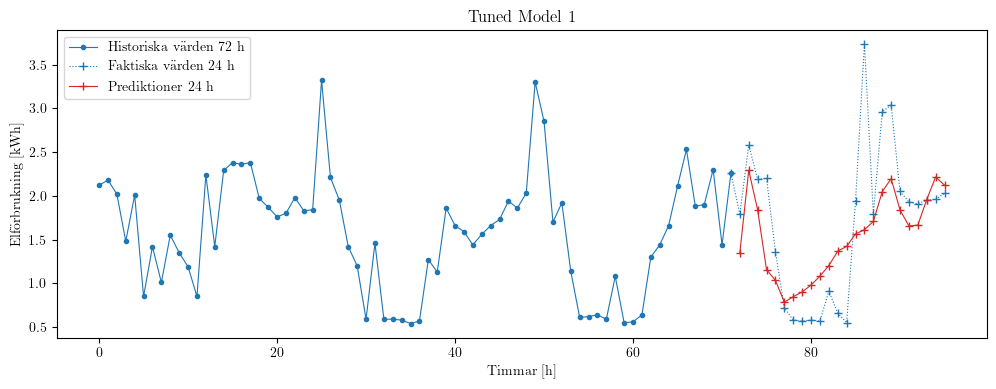

195/195 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step


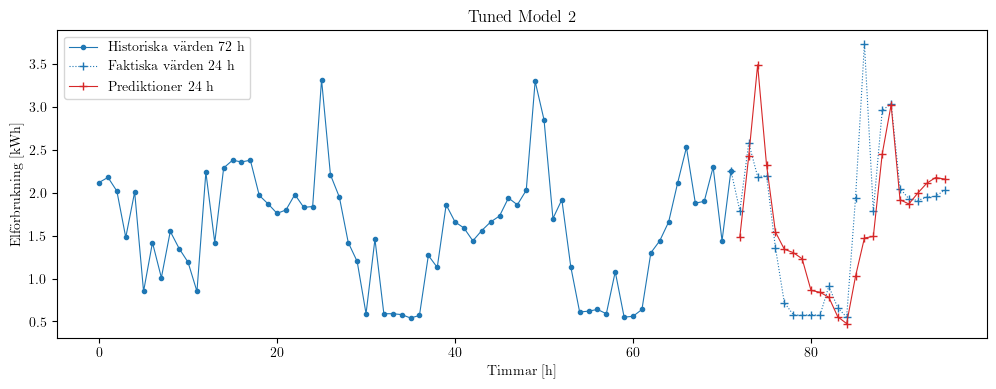

195/195 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step


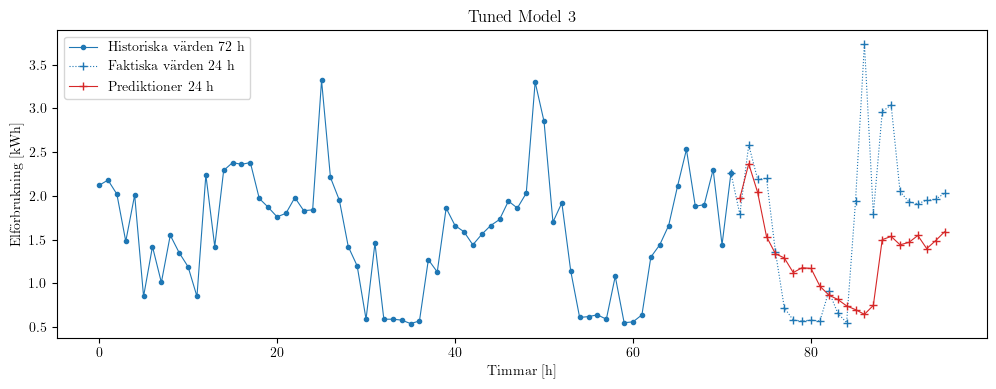

In [91]:
restune1 = plot_pred(model_tuned_1,X_test,y_test,start_index,index_hist,index_pred,dataname='Tuned Model 1',save = True)
restune2 = plot_pred(model_tuned_2,X_test,y_test,start_index,index_hist,index_pred,dataname='Tuned Model 2',save = True)
restune3 = plot_pred(model_tuned_3,X_test,y_test,start_index,index_hist,index_pred,dataname='Tuned Model 3',save = True)

## Function for plotting histograms and analyzing deviation.


In [99]:
def plothistogram(res_data,eps1,eps2,dataname):

    '''This function returns the standard deviation and plots histgrams
       In addition, to limits can be added and the probabillity of finding values within the limits are then calulated and presented in the plot.
    '''

    diff = res_data['Predictions'] - res_data['Actual values']
    std = diff.std()
    
    Y = np.linspace(0,250)
    linewidth = 1.2
    plt.plot(eps1 *np.ones(len(Y)),Y,color='black', linestyle = 'dashed', linewidth=linewidth)
    plt.plot(eps2 *np.ones(len(Y)),Y,color='tab:red', linestyle = 'dashed', linewidth=linewidth)
    
    plt.plot(-eps1 * np.ones(len(Y)),Y,color='black', linestyle = 'dashed', linewidth=linewidth)    
    plt.plot(-eps2 * np.ones(len(Y)),Y,color='tab:red', linestyle = 'dashed', linewidth=linewidth)
    plt.legend([f"$\\varepsilon_1 = {eps1}$",f"$\\varepsilon_2 = {eps2}$"],fontsize=14)
    
    plt.hist(diff,bins=200)
    
    p1 = []
    for val in diff:
        if abs(val) <= eps1:
            p1.append(val)

    P1 = np.round((len(p1)/len(diff)),2)
    
    p2 = []
    for val in diff:
        if abs(val) <= eps2:
            p2.append(val)

    P2 = np.round((len(p2)/len(diff)),2)

    plt.text(-5.5,0.9*max(Y), f"$P(|e| \leq \\varepsilon_1) = {100*P1}\,\%$",fontsize = 14)
    #plt.text(min(diff),0.8*max(y), f"$\\varepsilon_1 = {eps1}$",fontsize = 14)

    plt.text(-5.5,0.7*max(Y), f"$P(|e|\leq \\varepsilon_2) = {100*P2}\,\%$",fontsize = 14)
    #plt.text(min(diff),0.6*max(y), f"$\\varepsilon_2 = {eps2}$",fontsize = 14)

    plt.xlim([-6,6])

    plt.xlabel('Fel: $e = \hat{y}-y$ [kWh]',fontsize = 14)
    plt.title(dataname)
    plt.ylabel('Antal datapunkter',fontsize = 14)
    #plt.savefig(f'{dataname}.pdf')
    plt.show()
    
    return std

<>:35: SyntaxWarning: invalid escape sequence '\l'
<>:35: SyntaxWarning: invalid escape sequence '\,'
<>:38: SyntaxWarning: invalid escape sequence '\l'
<>:38: SyntaxWarning: invalid escape sequence '\,'
<>:43: SyntaxWarning: invalid escape sequence '\h'
<>:35: SyntaxWarning: invalid escape sequence '\l'
<>:35: SyntaxWarning: invalid escape sequence '\,'
<>:38: SyntaxWarning: invalid escape sequence '\l'
<>:38: SyntaxWarning: invalid escape sequence '\,'
<>:43: SyntaxWarning: invalid escape sequence '\h'
/var/folders/xl/schcbct544b8f32_b4484x5c0000gn/T/ipykernel_56255/1211545686.py:35: SyntaxWarning: invalid escape sequence '\l'
  plt.text(-5.5,0.9*max(Y), f"$P(|e| \leq \\varepsilon_1) = {100*P1}\,\%$",fontsize = 14)
/var/folders/xl/schcbct544b8f32_b4484x5c0000gn/T/ipykernel_56255/1211545686.py:35: SyntaxWarning: invalid escape sequence '\,'
  plt.text(-5.5,0.9*max(Y), f"$P(|e| \leq \\varepsilon_1) = {100*P1}\,\%$",fontsize = 14)
/var/folders/xl/schcbct544b8f32_b4484x5c0000gn/T/ipykern

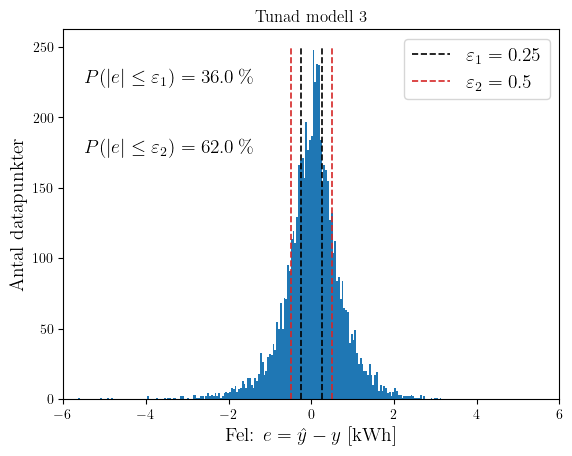

Standard deviation: 0.7149327409771544


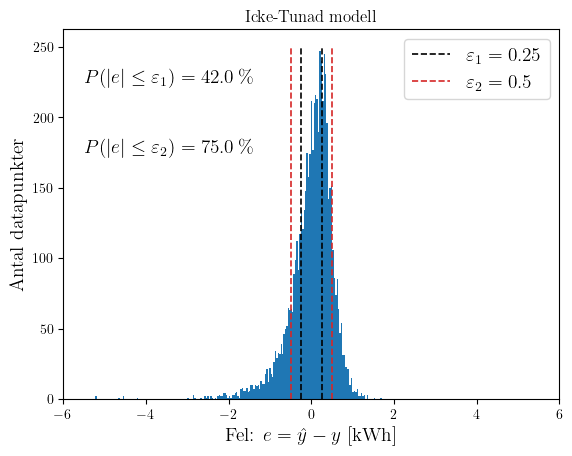

Standard deviation: 0.5285249113203606


In [100]:
eps1 = 0.25
eps2 = 0.5
#std_1 = plothistogram(restune1,eps1,eps2,'Tunad modell 1')

#std_2 = plothistogram(restune2,eps1,eps2,'Tunad modell 2')

std_3 = plothistogram(restune3,eps1,eps2,'Tunad modell 3')
print('Standard deviation:',std_3)

std_nontuned = plothistogram(res,eps1,eps2, 'Icke-tunad modell')

print('Standard deviation:',std_nontuned) 
